In [1]:
import os

GOOGLE_API_KEY =  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [2]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

In [3]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-001
models/gemini-1.5-flash-latest
models/gemini-1.5-pro
models/gemini-1.5-pro-001
models/gemini-1.5-pro-latest
models/gemini-pro
models/gemini-pro-vision


In [4]:
from pathlib import Path

input_image_path = Path("sample_images_for_img_rag")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

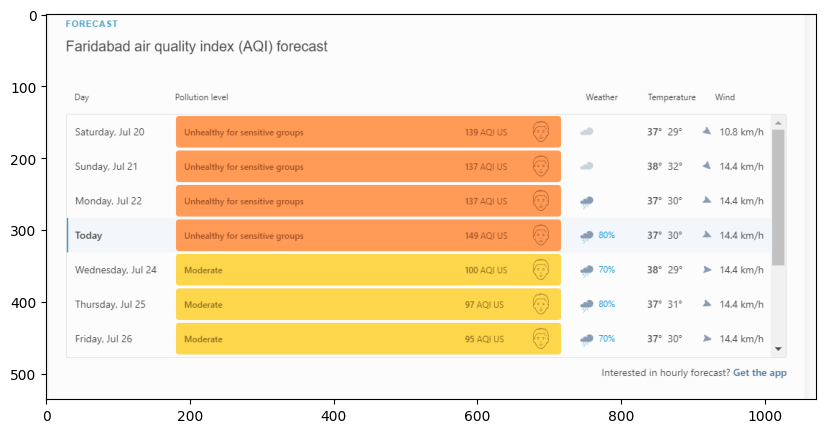

In [5]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class AQI_FORECAST(BaseModel):
    """Data model for a Google Restaurant."""

    temperature: str
    wind: str
    location: str
    pollution_level: str
    day_date: str
    AQI: str
    weather: str



aqi_img_s1 = r"C:\Users\Yatharth\Desktop\desktop1\AI\isro_hack\img_rag_testing\aqi_forecasting_sample\Screenshot 2024-07-23 042542.png"
image = Image.open(aqi_img_s1).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [6]:
!pip install llama_index.multi_modal_llms.gemini


DEPRECATION: Loading egg at c:\python11\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [7]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

In [8]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    r"C:\Users\Yatharth\Desktop\desktop1\AI\isro_hack\img_rag_testing\aqi_forecasting_sample"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-1.5-flash",
        AQI_FORECAST,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

> Raw output: ```json
{"temperature": "37° 29°", "wind": "10.8 km/h", "location": "Faridabad", "pollution_level": "Unhealthy for sensitive groups", "day_date": "Saturday, Jul 20", "AQI": "139 AQI US", "weather": "Cloudy"}
```
> Raw output: ```json
{"temperature": "37° 30°", "wind": "18 km/h", "location": "Gurugram", "pollution_level": "Unhealthy", "day_date": "Today", "AQI": "168 AQI US", "weather": "Cloudy 100%"}
```
> Raw output: ```json
{"temperature": "37° 30°", "wind": "18 km/h", "location": "Delhi", "pollution_level": "Unhealthy for sensitive groups", "day_date": "Today", "AQI": "132 AQI US", "weather": "90%"}
```


In [9]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

In [10]:
!pip install llama_index.vector_stores.qdrant 

  Using cached protobuf-5.27.2-cp310-abi3-win_amd64.whl.metadata (592 bytes)
Using cached protobuf-5.27.2-cp310-abi3-win_amd64.whl (426 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


DEPRECATION: Loading egg at c:\python11\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
googleapis-common-protos 1.63.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 5.27.2 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.2 which is incompatible.
google-api-core 2.18.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, 

In [11]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3newer")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/text-embedding-004", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

The weather in Faridabad on Saturday will be cloudy with an air quality classified as unhealthy for sensitive groups
The temperature will be between 29-37 degrees Celsius with a wind speed of 10.8 km/h




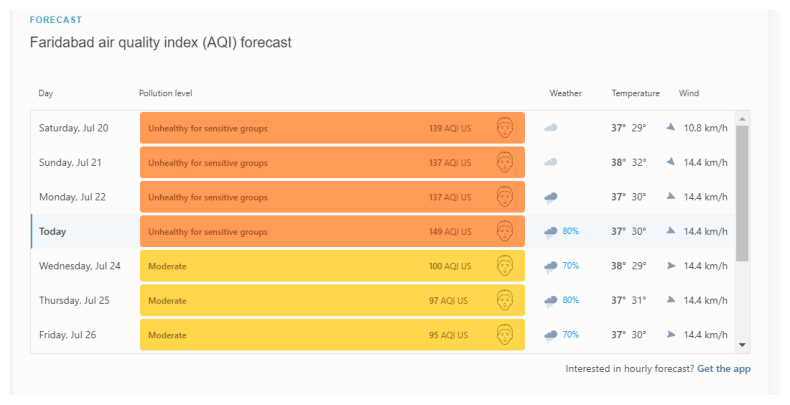

In [19]:
from llama_index.llms.gemini import Gemini

llm = Gemini(model="models/gemini-1.5-pro")

query_engine = index.as_query_engine(
    similarity_top_k=1,llm=llm,
)

response = query_engine.query(
    "What is the forecast for saturday at Faridabad"
)

x =str(response).split(". ")
for i in x:
    print(i)

aqi_img_s1 = r"C:\Users\Yatharth\Desktop\desktop1\AI\isro_hack\img_rag_testing\aqi_forecasting_sample\Screenshot 2024-07-23 042542.png"

image = Image.open(aqi_img_s1).convert("RGB")
plt.figure(figsize=(16, 5))
plt.axis("off")
plt.imshow(image);